# Comprehensive Model Comparison: Standard Transformer vs Diff Transformer vs Hymba vs Mamba

This notebook provides an in-depth comparison of four state-of-the-art architectures:

1. **Standard Transformer** - Baseline with modern improvements (RMSNorm, RoPE, GQA)
2. **Diff Transformer** - Differential attention mechanism
3. **Hymba** - Hybrid architecture (Attention + Mamba) with SWA and KV sharing
4. **Mamba** - Pure selective state space model

## Key Features:
- **Parameter Balancing**: All models tuned to have similar parameter counts
- **Attention Visualization**: Compare attention patterns across transformer variants
- **Comprehensive Metrics**: Training efficiency, inference speed, memory usage, quality

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import math
import gc
from contextlib import nullcontext
from IPython.display import display, HTML

# ===================== GPU Selection =====================
GPU_ID = 1  # Change to 0, 1, 2, etc.

if GPU_ID is not None and torch.cuda.is_available():
    if GPU_ID < torch.cuda.device_count():
        device = f"cuda:{GPU_ID}"
        torch.cuda.set_device(GPU_ID)
        print(f"Using GPU {GPU_ID}: {torch.cuda.get_device_name(GPU_ID)}")
    else:
        print(f"Warning: GPU {GPU_ID} not available. Available GPUs: {torch.cuda.device_count()}")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Falling back to: {device}")
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

# ===================== VRAM Management Utilities =====================
def get_gpu_memory_info():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**3)  # GB
        reserved = torch.cuda.memory_reserved() / (1024**3)  # GB
        return allocated, reserved
    return 0, 0

def clear_memory():
    """Clear GPU memory and run garbage collection"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def print_memory_status(label=""):
    """Print current memory status with optional label"""
    alloc, reserved = get_gpu_memory_info()
    if label:
        print(f"[Memory] {label}: {alloc:.2f}GB alloc, {reserved:.2f}GB reserved")
    else:
        print(f"[Memory] {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")

# ===================== Modern Visualization Utilities =====================
def set_modern_style():
    """Set modern, clean visualization style"""
    plt.style.use('default')
    sns.set_palette("husl")
    plt.rcParams.update({
        'figure.figsize': (14, 8),
        'axes.titlesize': 13,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'font.family': 'sans-serif',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
    })

set_modern_style()

# Print initial memory status
alloc, reserved = get_gpu_memory_info()
print(f"\n{'='*70}")
print(f"{'🚀 Comprehensive Model Comparison Framework':^70}")
print(f"{'='*70}")
print(f"Device: {device}")
print(f"Initial VRAM: {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")
print(f"{'='*70}\n")

Using GPU 1: NVIDIA A100 80GB PCIe
Available GPUs: 6
  GPU 0: NVIDIA A100 80GB PCIe
  GPU 1: NVIDIA A100 80GB PCIe
  GPU 2: NVIDIA A100 80GB PCIe
  GPU 3: NVIDIA A100 80GB PCIe
  GPU 4: NVIDIA A100 80GB PCIe
  GPU 5: NVIDIA A100 80GB PCIe

              🚀 Comprehensive Model Comparison Framework              
Device: cuda:1
Initial VRAM: 0.00GB allocated, 0.00GB reserved



## 1. Model Imports

In [2]:
# Import all models
from backbone.standard_transformer import StandardTransformer, ModelCfg as StdCfg, TrainCfg
from backbone.diff_transformer import DiffTransformer, ModelCfg as DiffCfg
from backbone.hymba_v3 import HymbaV3, ModelCfgV3 as HymbaCfg, build_everything as build_hymba
from backbone.mamba_model import MambaModel, ModelCfg as MambaCfg

print("All models imported successfully!")

2025-10-28 08:02:06.830401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-28 08:02:07.378363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


All models imported successfully!


## 2. Parameter Balancing

We carefully tune each model's architecture to achieve similar parameter counts for fair comparison.

In [3]:
# ===================== Configuration Presets =====================
# Choose a preset configuration:
# - "small": Fast testing with small models (current default)
# - "medium": Balanced comparison (~10M params, 512 seq_len)
# - "large": Large-scale comparison (~30M params, 1024 seq_len)

CONFIG_PRESET = "small"  # Change to "medium" or "large" for bigger tests

if CONFIG_PRESET == "small":
    # Small: Fast testing and visualization
    SEQ_LEN = 64
    BATCH_SIZE = 32
    VOCAB_SIZE = 5000
    STEPS = 500
    
    # Model sizes (~2-8M params, balanced for small-scale testing)
    std_d_model, std_n_layers = 256, 6
    diff_d_model, diff_n_layers = 256, 5
    hymba_d_model, hymba_n_layers = 256, 7
    mamba_d_model, mamba_n_layers = 320, 6  # ~6M params
    
elif CONFIG_PRESET == "medium":
    # Medium: Realistic comparison (~20-24M params)
    SEQ_LEN = 512
    BATCH_SIZE = 24
    VOCAB_SIZE = 8000
    STEPS = 1000
    
    # Model sizes balanced around ~23M params
    std_d_model, std_n_layers = 384, 8
    diff_d_model, diff_n_layers = 384, 7
    hymba_d_model, hymba_n_layers = 384, 8
    mamba_d_model, mamba_n_layers = 608, 8  # ~24M params (matching others)
    
elif CONFIG_PRESET == "large":
    # Large: Full-scale comparison (~50-56M params, requires significant VRAM)
    SEQ_LEN = 1024
    BATCH_SIZE = 16
    VOCAB_SIZE = 10000
    STEPS = 2000
    
    # Model sizes balanced around ~55M params
    std_d_model, std_n_layers = 512, 12
    diff_d_model, diff_n_layers = 512, 10
    hymba_d_model, hymba_n_layers = 512, 12
    mamba_d_model, mamba_n_layers = 768, 12  # ~53M params (matching others)

else:
    raise ValueError(f"Unknown CONFIG_PRESET: {CONFIG_PRESET}")

print(f"Configuration Preset: {CONFIG_PRESET.upper()}")
print(f"  SEQ_LEN={SEQ_LEN}, BATCH_SIZE={BATCH_SIZE}, VOCAB_SIZE={VOCAB_SIZE}")
print(f"  STEPS={STEPS}")
print(f"  Note: Using official mamba-ssm for efficient SSM operations")

# Training configuration
LR = 6e-4
WARMUP = int(STEPS * 0.2)

# Model-specific configs
# Standard Transformer
std_cfg = StdCfg(
    vocab_size=VOCAB_SIZE,
    d_model=std_d_model,
    n_layers=std_n_layers,
    n_heads=8,
    n_kv_heads=2,
    dropout=0.1,
    seq_len=SEQ_LEN
)

# Diff Transformer
diff_cfg = DiffCfg(
    vocab_size=VOCAB_SIZE,
    d_model=diff_d_model,
    n_layers=diff_n_layers,
    n_heads=8,
    n_kv_heads=2,
    dropout=0.1,
    seq_len=SEQ_LEN
)

# Hymba: balanced hybrid with proper Global layer placement (first, middle, last)
mid_layer = hymba_n_layers // 2
hymba_swa_layers = tuple([i for i in range(hymba_n_layers) if i not in (0, mid_layer, hymba_n_layers-1)])

hymba_cfg = HymbaCfg(
    vocab_size=VOCAB_SIZE,
    d_model=hymba_d_model,
    n_layers=hymba_n_layers,
    n_heads=8,
    n_kv_heads=2,
    dropout=0.1,
    seq_len=SEQ_LEN,
    swa_layers=hymba_swa_layers if hymba_n_layers > 2 else (),
    swa_window=min(256, SEQ_LEN // 2)
)

# Mamba: d_model adjusted per preset to match other models' parameter count
mamba_cfg = MambaCfg(
    vocab_size=VOCAB_SIZE,
    d_model=mamba_d_model,
    n_layers=mamba_n_layers,
    state_size=16,
    d_conv=4,
    expand=2,
    dropout=0.1,
    seq_len=SEQ_LEN
)

print(f"\nModel Configurations:")
print(f"  Standard: d_model={std_d_model}, n_layers={std_n_layers}")
print(f"  Diff:     d_model={diff_d_model}, n_layers={diff_n_layers}")
print(f"  Hymba:    d_model={hymba_d_model}, n_layers={hymba_n_layers}")
print(f"    - Global layers: [0, {mid_layer}, {hymba_n_layers-1}]")
print(f"    - SWA layers: {list(hymba_swa_layers)}")
print(f"  Mamba:    d_model={mamba_d_model}, n_layers={mamba_n_layers} (adjusted for similar param count)")

Configuration Preset: SMALL
  SEQ_LEN=64, BATCH_SIZE=32, VOCAB_SIZE=5000
  STEPS=500
  Note: Using official mamba-ssm for efficient SSM operations

Model Configurations:
  Standard: d_model=256, n_layers=6
  Diff:     d_model=256, n_layers=5
  Hymba:    d_model=256, n_layers=7
    - Global layers: [0, 3, 6]
    - SWA layers: [1, 2, 4, 5]
  Mamba:    d_model=320, n_layers=6 (adjusted for similar param count)


## 3. Build Data and Models

In [4]:
# Build data (using Hymba's build function for consistency)
print("Loading dataset...")
_, tok, train_dl, val_dl = build_hymba(seq_len=SEQ_LEN, bs=BATCH_SIZE, vocab_size=VOCAB_SIZE)
print(f"Dataset ready: {len(train_dl)} train batches, {len(val_dl)} val batches")

Loading dataset...
Loading corpus...
Training tokenizer (vocab_size=5000)...


Building dataloaders (seq_len=64, bs=32)...
Dataset ready: 135 train batches, 8 val batches


In [5]:
# Build models
models = {}
param_counts = {}

print("Building models...\n")

# Standard Transformer
print("1. Standard Transformer")
std_model = StandardTransformer(std_cfg).to(device)
std_params = sum(p.numel() for p in std_model.parameters() if p.requires_grad)
models['Standard'] = std_model
param_counts['Standard'] = std_params
print(f"   Parameters: {std_params:,}\n")

# Diff Transformer
print("2. Diff Transformer")
diff_model = DiffTransformer(diff_cfg).to(device)
diff_params = sum(p.numel() for p in diff_model.parameters() if p.requires_grad)
models['Diff'] = diff_model
param_counts['Diff'] = diff_params
print(f"   Parameters: {diff_params:,}\n")

# Hymba
print("3. Hymba (Hybrid)")
hymba_model = HymbaV3(hymba_cfg).to(device)
hymba_params = sum(p.numel() for p in hymba_model.parameters() if p.requires_grad)
models['Hymba'] = hymba_model
param_counts['Hymba'] = hymba_params
print(f"   Parameters: {hymba_params:,}")
display(hymba_model.layer_table())
print()

# Mamba
print("4. Mamba (SSM)")
mamba_model = MambaModel(mamba_cfg).to(device)
mamba_params = sum(p.numel() for p in mamba_model.parameters() if p.requires_grad)
models['Mamba'] = mamba_model
param_counts['Mamba'] = mamba_params
print(f"   Parameters: {mamba_params:,}\n")

# Summary
print("="*60)
print("Parameter Count Summary:")
for name, count in param_counts.items():
    print(f"  {name:15s}: {count:>10,} ({count/1e6:.2f}M)")
print("="*60)

Building models...

1. Standard Transformer
   Parameters: 8,264,960

2. Diff Transformer
   Parameters: 8,139,136

3. Hymba (Hybrid)
   Parameters: 8,431,744


,layer,attn,kv_owner,kv_share_group,differential
0,0,GLOBAL(DIFF),0,0,True
1,1,LOCAL(SWA),1,1,False
2,2,LOCAL(SWA),1,1,False
3,3,GLOBAL(DIFF),3,2,True
4,4,LOCAL(SWA),4,3,False
5,5,LOCAL(SWA),4,3,False
6,6,GLOBAL(DIFF),6,4,True



4. Mamba (SSM)
   Parameters: 5,653,440

Parameter Count Summary:
  Standard       :  8,264,960 (8.26M)
  Diff           :  8,139,136 (8.14M)
  Hymba          :  8,431,744 (8.43M)
  Mamba          :  5,653,440 (5.65M)


## 4. Training Functions

In [6]:
def train_model(model, train_dl, val_dl, model_name, steps=STEPS):
    """Train a model and return metrics"""
    # Import train_loop from the appropriate module
    if model_name == 'Standard':
        from backbone.standard_transformer import train_loop
    elif model_name == 'Diff':
        from backbone.diff_transformer import train_loop
    elif model_name == 'Hymba':
        from backbone.hymba_v3 import train_loop
    else:  # Mamba
        from backbone.mamba_model import train_loop
    
    tcfg = TrainCfg(
        seq_len=SEQ_LEN,
        batch_size=BATCH_SIZE,
        steps=steps,
        lr=LR,
        warmup=WARMUP,
        amp=True,
        grad_clip=1.0
    )
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    print_memory_status(f"Before training {model_name}")
    
    torch.cuda.reset_peak_memory_stats() if device == "cuda" else None
    start_time = time.time()
    
    stats = train_loop(model, train_dl, val_dl, tcfg, device=device)
    
    elapsed = time.time() - start_time
    peak_mem = torch.cuda.max_memory_allocated() / (1024**2) if device == "cuda" else 0.0
    
    stats['model'] = model_name
    stats['time_s'] = elapsed
    stats['params'] = param_counts[model_name]
    stats['peak_mem_mb'] = peak_mem
    
    print_memory_status(f"After training {model_name}")
    
    # Clear memory after training
    clear_memory()
    print_memory_status(f"After clearing cache")
    
    return stats

## 5. Evaluation Functions

In [7]:
@torch.no_grad()
def evaluate_ppl(model, val_dl, amp=True):
    """Evaluate perplexity on validation set"""
    model.eval()
    nll = 0.0
    tok_count = 0
    ctx = (torch.amp.autocast("cuda") if (amp and device=="cuda") else nullcontext())
    
    with ctx:
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb, targets=yb)
            nll += out["loss"].item() * xb.numel()
            tok_count += xb.numel()
    
    return math.exp(nll / max(1, tok_count))

@torch.no_grad()
def bench_generate(model, prompt_len=128, gen_len=128, warmup=1, repeat=3):
    """Benchmark generation speed"""
    model.eval()
    device_t = next(model.parameters()).device
    
    if hasattr(model, 'cfg'):
        vocab = model.cfg.vocab_size
    else:
        vocab = VOCAB_SIZE
    
    torch.manual_seed(42)
    prompt = torch.randint(0, vocab, (1, prompt_len), device=device_t)

    # Warmup
    for _ in range(warmup):
        try:
            _ = model.generate(prompt, max_new_tokens=16)
        except:
            pass

    if device_t.type == "cuda":
        torch.cuda.reset_peak_memory_stats()

    times = []
    for _ in range(repeat):
        if device_t.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.time()
        try:
            _ = model.generate(prompt, max_new_tokens=gen_len)
        except:
            pass
        if device_t.type == "cuda":
            torch.cuda.synchronize()
        times.append(time.time() - t0)

    sec = sum(times) / len(times)
    tps = int((prompt_len + gen_len) / sec)
    mem = 0.0
    if device_t.type == "cuda":
        mem = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "gen_latency_s": round(sec, 3),
        "gen_tps": tps,
        "gen_peak_mb": round(mem, 2),
    }

## 6. Train All Models

In [8]:
results = []

for name, model in models.items():
    stats = train_model(model, train_dl, val_dl, name, steps=STEPS)
    results.append(stats)
    
    # Move model to CPU and clear VRAM after training to free up memory
    model.cpu()
    clear_memory()
    print_memory_status(f"After moving {name} to CPU")

# Note: Models are now on CPU. They will be moved back to GPU for generation benchmarks


Training Standard
[Memory] Before training Standard: 0.11GB alloc, 0.13GB reserved
[    1] loss=8.688 lr=6.00e-06
[   50] loss=6.493 lr=3.00e-04
[  100] loss=5.868 lr=6.00e-04
[  150] loss=5.548 lr=5.77e-04
[  200] loss=5.458 lr=5.12e-04
[  250] loss=5.350 lr=4.15e-04
[  300] loss=5.312 lr=3.00e-04
[  350] loss=5.212 lr=1.85e-04
[  400] loss=5.215 lr=8.79e-05
[  450] loss=5.152 lr=2.28e-05
[  500] loss=5.074 lr=0.00e+00
[Memory] After training Standard: 0.13GB alloc, 0.77GB reserved
[Memory] After clearing cache: 0.13GB alloc, 0.17GB reserved
[Memory] After moving Standard to CPU: 0.10GB alloc, 0.16GB reserved

Training Diff
[Memory] Before training Diff: 0.10GB alloc, 0.16GB reserved
[    1] loss=8.690 lr=6.00e-06
[   50] loss=6.429 lr=3.00e-04
[  100] loss=5.855 lr=6.00e-04
[  150] loss=5.562 lr=5.77e-04
[  200] loss=5.417 lr=5.12e-04
[  250] loss=5.305 lr=4.15e-04
[  300] loss=5.265 lr=3.00e-04
[  350] loss=5.129 lr=1.85e-04
[  400] loss=5.127 lr=8.79e-05
[  450] loss=5.041 lr=2.28

## 7. Generation Benchmarks

In [9]:
gen_results = []

print("\n" + "="*60)
print("Generation Benchmarking (one model at a time to save VRAM)")
print("="*60)

for name, model in models.items():
    print(f"\nBenchmarking {name} generation...")
    print_memory_status(f"Before {name} generation benchmark")
    
    # Move model to GPU
    model.to(device)
    print_memory_status(f"{name} moved to GPU")
    
    bench = bench_generate(model, prompt_len=128, gen_len=128)
    bench['model'] = name
    gen_results.append(bench)
    print(f"{name}: {bench['gen_tps']} tokens/s, {bench['gen_latency_s']}s latency, {bench['gen_peak_mb']:.1f}MB")
    
    # Move back to CPU and clear cache
    model.cpu()
    clear_memory()
    print_memory_status(f"After {name} benchmark, moved to CPU")

print("\n" + "="*60)
print("Generation benchmarking completed")
print("="*60)


Generation Benchmarking (one model at a time to save VRAM)

Benchmarking Standard generation...
[Memory] Before Standard generation benchmark: 0.02GB alloc, 0.06GB reserved
[Memory] Standard moved to GPU: 0.05GB alloc, 0.08GB reserved
Standard: 197 tokens/s, 1.296s latency, 51.1MB
[Memory] After Standard benchmark, moved to CPU: 0.02GB alloc, 0.06GB reserved

Benchmarking Diff generation...
[Memory] Before Diff generation benchmark: 0.02GB alloc, 0.06GB reserved
[Memory] Diff moved to GPU: 0.05GB alloc, 0.08GB reserved
Diff: 136 tokens/s, 1.88s latency, 52.7MB
[Memory] After Diff benchmark, moved to CPU: 0.02GB alloc, 0.06GB reserved

Benchmarking Hymba generation...
[Memory] Before Hymba generation benchmark: 0.02GB alloc, 0.06GB reserved
[Memory] Hymba moved to GPU: 0.05GB alloc, 0.09GB reserved
Hymba: 153 tokens/s, 1.669s latency, 53.2MB
[Memory] After Hymba benchmark, moved to CPU: 0.02GB alloc, 0.06GB reserved

Benchmarking Mamba generation...
[Memory] Before Mamba generation ben

## 8. Results Summary

In [10]:
print(f"\n{'='*70}")
print(f"{'📊 TRAINING RESULTS':^70}")
print(f"{'='*70}\n")

# Prepare training dataframe
df_train = pd.DataFrame(results)
df_train['Params (M)'] = df_train['params'] / 1e6
df_train['Time (min)'] = df_train['time_s'] / 60

# Display formatted table
display_cols = ['model', 'Params (M)', 'train_loss', 'val_loss', 'ppl', 'tps', 'Time (min)']
df_display = df_train[display_cols].copy()
df_display.columns = ['Model', 'Params (M)', 'Train Loss', 'Val Loss', 'Perplexity', 'Throughput', 'Time (min)']

# Round for display
for col in ['Params (M)', 'Train Loss', 'Val Loss', 'Perplexity', 'Time (min)']:
    df_display[col] = df_display[col].round(2)

# Apply styling
def highlight_best(s, higher_is_better=False):
    if s.name in ['Val Loss', 'Perplexity', 'Train Loss', 'Time (min)']:
        is_best = s == s.min()
    else:
        is_best = s == s.max()
    return ['background-color: #90EE90; font-weight: bold' if v else '' for v in is_best]

styled = df_display.style.apply(highlight_best, subset=['Val Loss', 'Perplexity', 'Throughput'])
display(styled)

# Performance summary
best_quality = df_display.loc[df_display['Val Loss'].idxmin(), 'Model']
best_speed = df_display.loc[df_display['Throughput'].idxmax(), 'Model']

print(f"\n🏆 Performance Leaders:")
print(f"   • Best Quality (Val Loss): {best_quality}")
print(f"   • Fastest Training: {best_speed}")


                          📊 TRAINING RESULTS                          



,Model,Params (M),Train Loss,Val Loss,Perplexity,Throughput,Time (min)
0,Standard,8.260000,5.660000,5.330000,205.660000,84359,0.200000
1,Diff,8.140000,5.600000,5.210000,182.760000,72005,0.240000
2,Hymba,8.430000,1.110000,1.080000,2.930000,48441,0.350000
3,Mamba,5.650000,5.560000,5.290000,197.460000,153928,0.110000



🏆 Performance Leaders:
   • Best Quality (Val Loss): Hymba
   • Fastest Training: Mamba


In [11]:
print(f"\n{'='*70}")
print(f"{'⚡ GENERATION RESULTS':^70}")
print(f"{'='*70}\n")

# Prepare generation dataframe
df_gen = pd.DataFrame(gen_results)
df_gen_display = df_gen.copy()
df_gen_display.columns = ['Latency (s)', 'Throughput (tok/s)', 'Peak Mem (MB)', 'Model']
df_gen_display['Latency (s)'] = df_gen_display['Latency (s)'].round(3)
df_gen_display['Peak Mem (MB)'] = df_gen_display['Peak Mem (MB)'].round(0)

# Apply styling
styled_gen = df_gen_display.style.apply(highlight_best, subset=['Latency (s)', 'Throughput (tok/s)', 'Peak Mem (MB)'])
display(styled_gen)

# Generation summary
fastest = df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Model']
lowest_latency = df_gen_display.loc[df_gen_display['Latency (s)'].idxmin(), 'Model']

print(f"\n🏆 Generation Leaders:")
print(f"   • Fastest: {fastest} ({df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Throughput (tok/s)']} tok/s)")
print(f"   • Lowest Latency: {lowest_latency}")


                         ⚡ GENERATION RESULTS                         



,Latency (s),Throughput (tok/s),Peak Mem (MB),Model
0,1.296000,197,51.000000,Standard
1,1.880000,136,53.000000,Diff
2,1.669000,153,53.000000,Hymba
3,0.440000,581,44.000000,Mamba



🏆 Generation Leaders:
   • Fastest: Mamba (581 tok/s)
   • Lowest Latency: Mamba


## 9. Comprehensive Visualization


                   📊 VISUAL PERFORMANCE COMPARISON                    



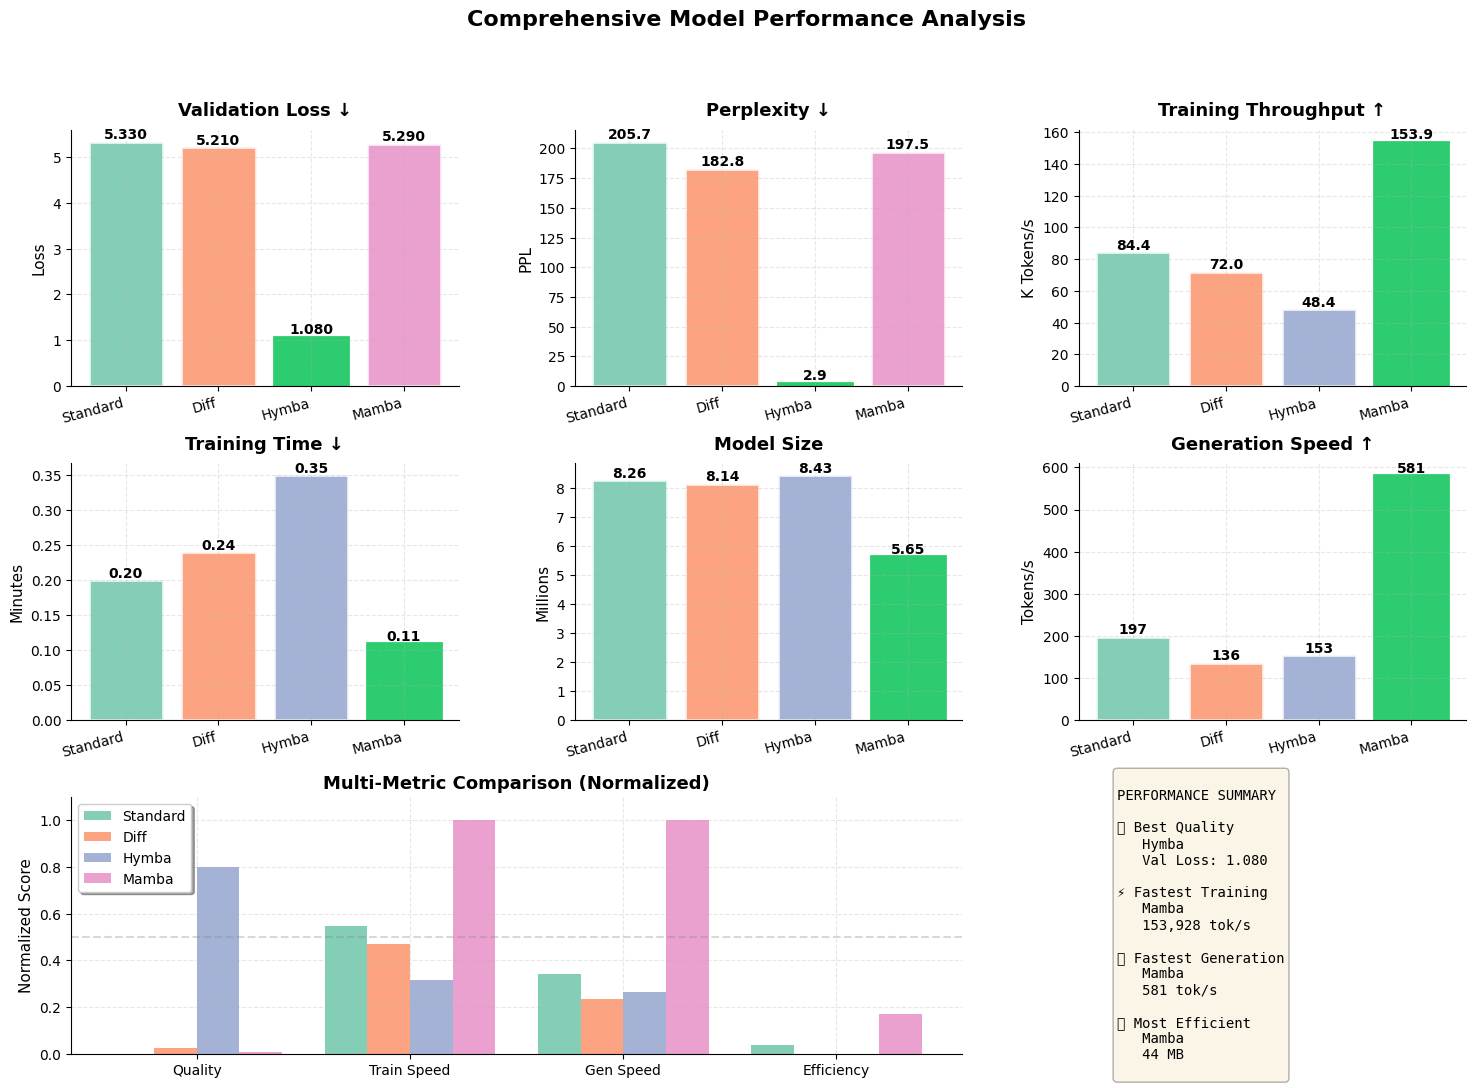

In [12]:
print(f"\n{'='*70}")
print(f"{'📊 VISUAL PERFORMANCE COMPARISON':^70}")
print(f"{'='*70}\n")

# Create modern comparison visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Modern color palette
colors = sns.color_palette("Set2", len(models))
model_names = df_display['Model'].tolist()

# Helper function for modern bar plots
def create_modern_barplot(ax, data, title, ylabel, higher_is_better=True, format_str='.2f'):
    bars = ax.bar(range(len(data)), data, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
    
    # Highlight best
    if higher_is_better:
        best_idx = data.argmax()
    else:
        best_idx = data.argmin()
    bars[best_idx].set_color('#2ecc71')
    bars[best_idx].set_alpha(1.0)
    
    # Add values on bars
    for i, (bar, val) in enumerate(zip(bars, data)):
        height = bar.get_height()
        if format_str == 'int':
            label = f'{int(val):,}'
        else:
            label = f'{val:{format_str}}'
        ax.text(bar.get_x() + bar.get_width()/2, height, label,
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Row 1: Quality Metrics
ax1 = fig.add_subplot(gs[0, 0])
create_modern_barplot(ax1, df_display['Val Loss'].values, 
                      'Validation Loss ↓', 'Loss', False, '.3f')

ax2 = fig.add_subplot(gs[0, 1])
create_modern_barplot(ax2, df_display['Perplexity'].values, 
                      'Perplexity ↓', 'PPL', False, '.1f')

ax3 = fig.add_subplot(gs[0, 2])
create_modern_barplot(ax3, df_display['Throughput'].values / 1000, 
                      'Training Throughput ↑', 'K Tokens/s', True, '.1f')

# Row 2: Efficiency Metrics
ax4 = fig.add_subplot(gs[1, 0])
create_modern_barplot(ax4, df_display['Time (min)'].values, 
                      'Training Time ↓', 'Minutes', False, '.2f')

ax5 = fig.add_subplot(gs[1, 1])
create_modern_barplot(ax5, df_display['Params (M)'].values, 
                      'Model Size', 'Millions', False, '.2f')

ax6 = fig.add_subplot(gs[1, 2])
create_modern_barplot(ax6, df_gen_display['Throughput (tok/s)'].values, 
                      'Generation Speed ↑', 'Tokens/s', True, 'int')

# Row 3: Comparative Analysis
ax7 = fig.add_subplot(gs[2, :2])
# Normalized radar-style comparison
metrics = ['Quality', 'Train Speed', 'Gen Speed', 'Efficiency']
models_data = []

for idx, model in enumerate(model_names):
    # Normalize metrics (0-1, higher is better)
    quality = 1 - (df_display.loc[idx, 'Val Loss'] / df_display['Val Loss'].max())
    train_speed = df_display.loc[idx, 'Throughput'] / df_display['Throughput'].max()
    gen_speed = df_gen_display.loc[idx, 'Throughput (tok/s)'] / df_gen_display['Throughput (tok/s)'].max()
    efficiency = 1 - (df_gen_display.loc[idx, 'Peak Mem (MB)'] / df_gen_display['Peak Mem (MB)'].max())
    models_data.append([quality, train_speed, gen_speed, efficiency])

x = np.arange(len(metrics))
width = 0.2

for i, (model, data) in enumerate(zip(model_names, models_data)):
    offset = width * (i - len(model_names)/2 + 0.5)
    bars = ax7.bar(x + offset, data, width, label=model, color=colors[i], alpha=0.8)

ax7.set_ylabel('Normalized Score', fontsize=11)
ax7.set_title('Multi-Metric Comparison (Normalized)', fontsize=13, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(metrics)
ax7.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax7.set_ylim(0, 1.1)
ax7.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)

# Row 3: Performance Summary
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

summary_text = f"""
PERFORMANCE SUMMARY

🏆 Best Quality
   {df_display.loc[df_display['Val Loss'].idxmin(), 'Model']}
   Val Loss: {df_display['Val Loss'].min():.3f}

⚡ Fastest Training
   {df_display.loc[df_display['Throughput'].idxmax(), 'Model']}
   {int(df_display['Throughput'].max()):,} tok/s

🚀 Fastest Generation
   {df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Model']}
   {int(df_gen_display['Throughput (tok/s)'].max())} tok/s

💾 Most Efficient
   {df_gen_display.loc[df_gen_display['Peak Mem (MB)'].idxmin(), 'Model']}
   {df_gen_display['Peak Mem (MB)'].min():.0f} MB
"""

ax8.text(0.1, 0.5, summary_text, transform=ax8.transAxes,
         fontsize=10, verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Comprehensive Model Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

## 10. Attention Map Visualization

**Enhanced Visualization Features:**
- **Standard Transformer**: Regular full attention
- **Diff Transformer**: Differential attention (attn1 - λ*attn2)
- **Hymba**: Detailed analysis of hybrid architecture
  - GLOBAL attention layers (0, 11): Full sequence context
  - SWA attention layers (1-10): Sliding window with limited context
  - Layer-wise statistics: sparsity, entropy, attention patterns

In [13]:
# Get a sample batch
sample_batch, _ = next(iter(val_dl))
sample_input = sample_batch[:1].to(device)  # Take first example

print(f"Sample input shape: {sample_input.shape}")
print(f"Visualizing attention for sequence length: {sample_input.size(1)}")

# Note: After training, models are on CPU. We'll move them to GPU temporarily for attention extraction
print_memory_status("Before attention extraction")

Sample input shape: torch.Size([1, 64])
Visualizing attention for sequence length: 64
[Memory] Before attention extraction: 0.02GB alloc, 0.06GB reserved


In [14]:
@torch.no_grad()
def get_attention_maps(model, input_ids, model_type):
    """Extract attention maps from a model"""
    model.eval()
    
    try:
        out = model(input_ids, return_attn=True)
        if 'attn_weights' in out and out['attn_weights'] is not None:
            return out['attn_weights']
    except Exception as e:
        print(f"  Warning: Could not extract attention from {model_type}: {e}")
        return None
    
    return None

# Get attention maps (move models to GPU one at a time)
print(f"\n{'='*70}")
print(f"{'🔍 EXTRACTING ATTENTION PATTERNS':^70}")
print(f"{'='*70}\n")

# Rebuild models dict to ensure it's a dict
models_dict = {
    'Standard': std_model,
    'Diff': diff_model,
    'Hymba': hymba_model,
    'Mamba': mamba_model
}

attn_maps = {}
for name, model in models_dict.items():
    if name in ['Standard', 'Diff', 'Hymba']:
        print(f"[{name}] Extracting attention patterns...")
        
        # Move to GPU temporarily
        model.to(device)
        
        maps = get_attention_maps(model, sample_input, name)
        if maps is not None and len(maps) > 0:
            # Filter out None values (from Hymba's Mamba layers)
            if name == 'Hymba':
                maps = [m for m in maps if m is not None]
            
            if len(maps) > 0:
                attn_maps[name] = maps
                print(f"  ✓ Extracted {len(maps)} layers")
            else:
                print(f"  ✗ No valid attention patterns")
        else:
            print(f"  ✗ No attention patterns available")
        
        # Move back to CPU
        model.cpu()
        clear_memory()

print(f"\n✓ Attention extraction completed for {len(attn_maps)} models")
print(f"{'='*70}\n")


                   🔍 EXTRACTING ATTENTION PATTERNS                    

[Standard] Extracting attention patterns...
  ✓ Extracted 6 layers
[Diff] Extracting attention patterns...
  ✓ Extracted 5 layers
[Hymba] Extracting attention patterns...
  ✓ Extracted 7 layers

✓ Attention extraction completed for 3 models



In [15]:
def visualize_hymba_attention_detailed(attn_maps_hymba, hymba_cfg, use_avg_heads=True):
    """
    Clean, focused Hymba attention visualization showing core architectural features
    
    Key insights from Hymba paper:
    - Attention naturally concentrates at sequence start (sink effect)
    - Meta tokens leverage this by positioning learnable tokens at sequence start
    - SWA: Each query attends to ALL meta tokens + local window
    - This minimizes wasted attention while reducing computation
    """
    if not attn_maps_hymba or len(attn_maps_hymba) == 0:
        print("⚠️  No Hymba attention maps available")
        return
    
    n_layers = len(attn_maps_hymba)
    swa_layers_set = set(hymba_cfg.swa_layers) if hasattr(hymba_cfg, 'swa_layers') else set()
    num_meta = hymba_cfg.num_meta_tokens if hasattr(hymba_cfg, 'num_meta_tokens') else 0
    swa_window = hymba_cfg.swa_window if hasattr(hymba_cfg, 'swa_window') else 32
    
    global_layers = [i for i in range(n_layers) if i not in swa_layers_set]
    swa_layers_list = sorted(list(swa_layers_set))
    T_total = attn_maps_hymba[0].shape[-1]
    
    print(f"\n{'='*70}")
    print(f"{'HYMBA ATTENTION ANALYSIS':^70}")
    print(f"{'='*70}")
    print(f"Layers: {n_layers} total | Global: {global_layers} | SWA: {swa_layers_list}")
    print(f"Sequence: {T_total} tokens ({num_meta} meta + {T_total-num_meta} regular)")
    print(f"SWA window: {swa_window} | Heads: {'averaged' if use_avg_heads else 'head-0'}")
    print(f"{'='*70}\n")
    
    def get_attn(layer_idx):
        attn_tensor = attn_maps_hymba[layer_idx]
        if use_avg_heads:
            return attn_tensor[0].mean(dim=0).cpu().numpy()
        else:
            return attn_tensor[0, 0].cpu().numpy()
    
    # ============================================================================
    # Figure: Core Attention Patterns (3 rows)
    # ============================================================================
    fig = plt.figure(figsize=(20, 11))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, 
                          height_ratios=[1, 0.8, 0.8])
    
    # Row 1: Layer samples showing Global vs SWA
    sample_layers = []
    if len(global_layers) > 0:
        sample_layers.append(('Global', global_layers[0]))
    if len(swa_layers_list) >= 2:
        sample_layers.append(('SWA', swa_layers_list[0]))
        sample_layers.append(('SWA', swa_layers_list[len(swa_layers_list)//2]))
    elif len(swa_layers_list) == 1:
        sample_layers.append(('SWA', swa_layers_list[0]))
    
    while len(sample_layers) < 3 and len(global_layers) > 1:
        sample_layers.append(('Global', global_layers[-1]))
    
    for idx, (layer_type, layer_num) in enumerate(sample_layers[:3]):
        ax = fig.add_subplot(gs[0, idx])
        attn = get_attn(layer_num)
        
        # Color scheme: cool blues for SWA, warm reds for Global
        if layer_type == 'SWA':
            cmap = 'Blues'
            title_color = '#1565C0'
        else:
            cmap = 'Reds'
            title_color = '#C62828'
        
        im = ax.imshow(attn, cmap=cmap, aspect='auto', interpolation='nearest', 
                      vmin=0, vmax=attn.max())
        
        ax.set_title(f'{layer_type} Layer {layer_num}', 
                    fontsize=13, fontweight='bold', color=title_color, pad=10)
        ax.set_xlabel('Key Position', fontsize=11)
        ax.set_ylabel('Query Position', fontsize=11)
        
        # Meta token boundary
        if num_meta > 0:
            ax.axhline(y=num_meta-0.5, color='gold', linestyle='-', linewidth=2.5, alpha=0.9)
            ax.axvline(x=num_meta-0.5, color='gold', linestyle='-', linewidth=2.5, alpha=0.9)
            ax.text(num_meta/2, -2, 'META', ha='center', fontsize=10, 
                   color='gold', fontweight='bold')
        
        # SWA window indicators
        if layer_type == 'SWA':
            for q_pos in [num_meta if num_meta > 0 else 0, T_total//2, T_total-1]:
                k_start = max(num_meta, q_pos - swa_window + 1)
                k_end = q_pos + 1
                ax.plot([k_start, k_end], [q_pos, q_pos], 
                       color='lime', linewidth=2, alpha=0.85)
            
            ax.text(0.98, 0.02, f'w={swa_window}', transform=ax.transAxes,
                   fontsize=10, color='lime', ha='right', va='bottom', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.6))
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Row 2: Attention distribution analysis
    # Left: Meta token attention across layers
    ax_meta = fig.add_subplot(gs[1, 0])
    if num_meta > 0:
        meta_attn_by_layer = []
        for li in range(n_layers):
            attn = attn_maps_hymba[li][0]
            # Average attention FROM regular tokens TO meta tokens
            avg_to_meta = attn[:, num_meta:, :num_meta].mean().item()
            meta_attn_by_layer.append(avg_to_meta)
        
        colors = ['#C62828' if li in global_layers else '#1565C0' for li in range(n_layers)]
        bars = ax_meta.bar(range(n_layers), meta_attn_by_layer, color=colors, 
                          alpha=0.8, edgecolor='white', linewidth=1.5)
        
        ax_meta.set_title('Attention to Meta Tokens', fontsize=12, fontweight='bold')
        ax_meta.set_xlabel('Layer', fontsize=11)
        ax_meta.set_ylabel('Avg Attention Weight', fontsize=11)
        ax_meta.set_xticks(range(n_layers))
        ax_meta.set_xticklabels([f'{i}' for i in range(n_layers)], fontsize=9)
        ax_meta.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#C62828', alpha=0.8, label='Global'),
                          Patch(facecolor='#1565C0', alpha=0.8, label='SWA')]
        ax_meta.legend(handles=legend_elements, loc='upper right', fontsize=9)
    else:
        ax_meta.text(0.5, 0.5, 'No Meta Tokens', ha='center', va='center', 
                    fontsize=14, color='gray')
        ax_meta.axis('off')
    
    # Middle: Attention sparsity
    ax_sparsity = fig.add_subplot(gs[1, 1])
    sparsity = []
    for li in range(n_layers):
        attn = attn_maps_hymba[li][0]
        sparse_pct = (attn < 0.01).float().mean().item() * 100
        sparsity.append(sparse_pct)
    
    colors = ['#C62828' if li in global_layers else '#1565C0' for li in range(n_layers)]
    bars = ax_sparsity.bar(range(n_layers), sparsity, color=colors, 
                           alpha=0.8, edgecolor='white', linewidth=1.5)
    
    ax_sparsity.set_title('Attention Sparsity (< 0.01)', fontsize=12, fontweight='bold')
    ax_sparsity.set_xlabel('Layer', fontsize=11)
    ax_sparsity.set_ylabel('Sparsity (%)', fontsize=11)
    ax_sparsity.set_xticks(range(n_layers))
    ax_sparsity.set_xticklabels([f'{i}' for i in range(n_layers)], fontsize=9)
    ax_sparsity.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Right: Attention entropy
    ax_entropy = fig.add_subplot(gs[1, 2])
    entropy = []
    for li in range(n_layers):
        attn = attn_maps_hymba[li][0]
        attn_safe = attn + 1e-10
        ent = -(attn_safe * torch.log(attn_safe)).sum(dim=-1).mean().item()
        entropy.append(ent)
    
    colors = ['#C62828' if li in global_layers else '#1565C0' for li in range(n_layers)]
    bars = ax_entropy.bar(range(n_layers), entropy, color=colors, 
                          alpha=0.8, edgecolor='white', linewidth=1.5)
    
    ax_entropy.set_title('Attention Entropy', fontsize=12, fontweight='bold')
    ax_entropy.set_xlabel('Layer', fontsize=11)
    ax_entropy.set_ylabel('Entropy (nats)', fontsize=11)
    ax_entropy.set_xticks(range(n_layers))
    ax_entropy.set_xticklabels([f'{i}' for i in range(n_layers)], fontsize=9)
    ax_entropy.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Row 3: Unified attention distribution across ALL layers
    ax_unified = fig.add_subplot(gs[2, :])
    
    # Compute attention breakdown for ALL layers
    meta_attn_all = []
    window_attn_all = []
    outside_attn_all = []
    layer_labels = []
    
    for li in range(n_layers):
        attn = attn_maps_hymba[li][0].cpu()
        T = attn.shape[-1]
        
        # Meta attention
        if num_meta > 0:
            meta_mask = torch.zeros_like(attn)
            meta_mask[:, :, :num_meta] = 1
            meta_avg = (attn * meta_mask).sum() / meta_mask.sum()
            meta_attn_all.append(meta_avg.item())
        else:
            meta_attn_all.append(0)
        
        # Window attention (excluding meta)
        window_mask = torch.zeros_like(attn)
        if li in swa_layers_set:
            # SWA layer: compute window
            for q in range(T):
                k_start = max(num_meta, q - swa_window + 1)
                k_end = q + 1
                window_mask[:, q, k_start:k_end] = 1
            if num_meta > 0:
                window_mask[:, :, :num_meta] = 0
        else:
            # Global layer: all non-meta positions count as "window"
            window_mask[:, :, :] = 1
            if num_meta > 0:
                window_mask[:, :, :num_meta] = 0
        
        window_avg = (attn * window_mask).sum() / window_mask.sum()
        window_attn_all.append(window_avg.item())
        
        # Outside attention (only meaningful for SWA layers)
        if li in swa_layers_set:
            outside_mask = 1 - window_mask
            if num_meta > 0:
                outside_mask[:, :, :num_meta] = 0
            outside_sum = outside_mask.sum()
            if outside_sum > 0:
                outside_avg = (attn * outside_mask).sum() / outside_sum
                outside_attn_all.append(outside_avg.item())
            else:
                outside_attn_all.append(0)
        else:
            # Global layers have no "outside"
            outside_attn_all.append(0)
        
        # Layer label
        if li in global_layers:
            layer_labels.append(f'L{li}\nGlobal')
        else:
            layer_labels.append(f'L{li}\nSWA')
    
    # Plot stacked or grouped bars
    x = np.arange(n_layers)
    width = 0.25
    
    if num_meta > 0:
        bars1 = ax_unified.bar(x - width, meta_attn_all, width, label='Meta Tokens',
                               color='gold', alpha=0.9, edgecolor='white', linewidth=1.5)
        bars2 = ax_unified.bar(x, window_attn_all, width, label='Window/Full',
                               color='#1565C0', alpha=0.85, edgecolor='white', linewidth=1.5)
        bars3 = ax_unified.bar(x + width, outside_attn_all, width, label='Outside (SWA only)',
                               color='#757575', alpha=0.75, edgecolor='white', linewidth=1.5)
    else:
        bars1 = ax_unified.bar(x - width/2, window_attn_all, width, label='Window/Full',
                               color='#1565C0', alpha=0.85, edgecolor='white', linewidth=1.5)
        bars2 = ax_unified.bar(x + width/2, outside_attn_all, width, label='Outside (SWA only)',
                               color='#757575', alpha=0.75, edgecolor='white', linewidth=1.5)
    
    # Highlight layer types with background colors
    for li in range(n_layers):
        if li in global_layers:
            ax_unified.axvspan(li - 0.5, li + 0.5, alpha=0.08, color='red', zorder=0)
        else:
            ax_unified.axvspan(li - 0.5, li + 0.5, alpha=0.08, color='blue', zorder=0)
    
    ax_unified.set_title('Attention Distribution Across All Layers', 
                         fontsize=13, fontweight='bold', pad=15)
    ax_unified.set_xlabel('Layer', fontsize=11)
    ax_unified.set_ylabel('Avg Attention Weight', fontsize=11)
    ax_unified.set_xticks(x)
    ax_unified.set_xticklabels(layer_labels, fontsize=9, rotation=0, ha='center')
    ax_unified.legend(fontsize=10, loc='upper left', framealpha=0.95)
    ax_unified.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add text annotations showing layer type in legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gold', alpha=0.9, label='Meta Tokens'),
        Patch(facecolor='#1565C0', alpha=0.85, label='Window/Full'),
        Patch(facecolor='#757575', alpha=0.75, label='Outside (SWA only)'),
        Patch(facecolor='red', alpha=0.15, label='Global Layer (bg)'),
        Patch(facecolor='blue', alpha=0.15, label='SWA Layer (bg)')
    ]
    ax_unified.legend(handles=legend_elements, fontsize=9, loc='upper right', 
                     framealpha=0.95, ncol=2)
    
    plt.suptitle('Hymba Attention Architecture Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"{'SUMMARY':^70}")
    print(f"{'='*70}")
    if num_meta > 0:
        print(f"Meta Tokens: {num_meta} tokens at positions [0:{num_meta}]")
        print(f"  • Leverage attention sink effect at sequence start")
        print(f"  • Globally accessible from all queries in SWA layers")
        avg_meta = np.mean([meta_attn_all[i] for i in range(n_layers)])
        print(f"  • Average attention across all layers: {avg_meta:.4f}")
    print(f"\nSWA Mechanism:")
    print(f"  • Window size: {swa_window} tokens")
    print(f"  • Query q attends to: Meta[0:{num_meta}] + Window[max({num_meta}, q-{swa_window}+1), q]")
    if len(swa_layers_list) > 0:
        swa_meta = np.mean([meta_attn_all[i] for i in swa_layers_list])
        swa_window_avg = np.mean([window_attn_all[i] for i in swa_layers_list])
        swa_outside = np.mean([outside_attn_all[i] for i in swa_layers_list])
        print(f"  • SWA layer attention breakdown:")
        print(f"    - Meta: {swa_meta:.3f} | Window: {swa_window_avg:.3f} | Outside: {swa_outside:.3f}")
    if len(global_layers) > 0:
        global_meta = np.mean([meta_attn_all[i] for i in global_layers])
        global_full = np.mean([window_attn_all[i] for i in global_layers])
        print(f"  • Global layer attention breakdown:")
        print(f"    - Meta: {global_meta:.3f} | Full: {global_full:.3f}")
    print(f"{'='*70}\n")


def visualize_attention_comparison(attn_maps, layer_idx=0, use_avg_heads=True):
    """
    Clean 3-model comparison focused on attention pattern differences
    """
    if not attn_maps:
        print("⚠️  No attention maps available")
        return
    
    fig = plt.figure(figsize=(18, 5.5))
    gs = fig.add_gridspec(1, 3, wspace=0.25)
    
    title_suffix = " (avg)" if use_avg_heads else " (h0)"
    subplot_idx = 0
    
    # Standard Transformer
    if 'Standard' in attn_maps:
        ax = fig.add_subplot(gs[0, subplot_idx])
        layer_attn = attn_maps['Standard'][min(layer_idx, len(attn_maps['Standard'])-1)]
        if use_avg_heads:
            attn = layer_attn[0].mean(dim=0).cpu().numpy()
        else:
            attn = layer_attn[0, 0].cpu().numpy()
        
        im = ax.imshow(attn, cmap='Purples', aspect='auto', interpolation='nearest', 
                      vmin=0, vmax=attn.max())
        ax.set_title(f'Standard Transformer\nLayer {layer_idx}{title_suffix}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Key Position', fontsize=10)
        ax.set_ylabel('Query Position', fontsize=10)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        subplot_idx += 1
    
    # Diff Transformer
    if 'Diff' in attn_maps:
        ax = fig.add_subplot(gs[0, subplot_idx])
        layer_attn = attn_maps['Diff'][min(layer_idx, len(attn_maps['Diff'])-1)]
        _, _, attn_diff = layer_attn
        if use_avg_heads:
            ad = attn_diff[0].mean(dim=0).cpu().numpy()
        else:
            ad = attn_diff[0, 0].cpu().numpy()
        
        vmax = max(abs(ad.min()), abs(ad.max()))
        im = ax.imshow(ad, cmap='RdBu_r', aspect='auto', interpolation='nearest', 
                      vmin=-vmax, vmax=vmax)
        ax.set_title(f'Diff Transformer\nLayer {layer_idx}{title_suffix}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Key Position', fontsize=10)
        ax.set_ylabel('Query Position', fontsize=10)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        subplot_idx += 1
    
    # Hymba
    if 'Hymba' in attn_maps:
        ax = fig.add_subplot(gs[0, subplot_idx])
        layer_attn = attn_maps['Hymba'][min(layer_idx, len(attn_maps['Hymba'])-1)]
        if use_avg_heads:
            attn = layer_attn[0].mean(dim=0).cpu().numpy()
        else:
            attn = layer_attn[0, 0].cpu().numpy()
        
        # Determine layer type
        n_layers = len(attn_maps['Hymba'])
        is_first_or_last = (layer_idx == 0 or layer_idx == n_layers - 1)
        layer_type = "Global" if is_first_or_last else "SWA"
        
        im = ax.imshow(attn, cmap='Greens', aspect='auto', interpolation='nearest', 
                      vmin=0, vmax=attn.max())
        ax.set_title(f'Hymba ({layer_type})\nLayer {layer_idx}{title_suffix}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Key Position', fontsize=10)
        ax.set_ylabel('Query Position', fontsize=10)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        subplot_idx += 1
    
    plt.suptitle(f'Attention Pattern Comparison - Layer {layer_idx}', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("✓ Clean, focused visualization functions loaded")

✓ Clean, focused visualization functions loaded



                      📊 ATTENTION VISUALIZATION                       

🔬 Detailed Hymba Analysis (Multi-Head Averaged)


                       HYMBA ATTENTION ANALYSIS                       
Layers: 7 total | Global: [0, 3, 6] | SWA: [1, 2, 4, 5]
Sequence: 68 tokens (4 meta + 64 regular)
SWA window: 32 | Heads: averaged



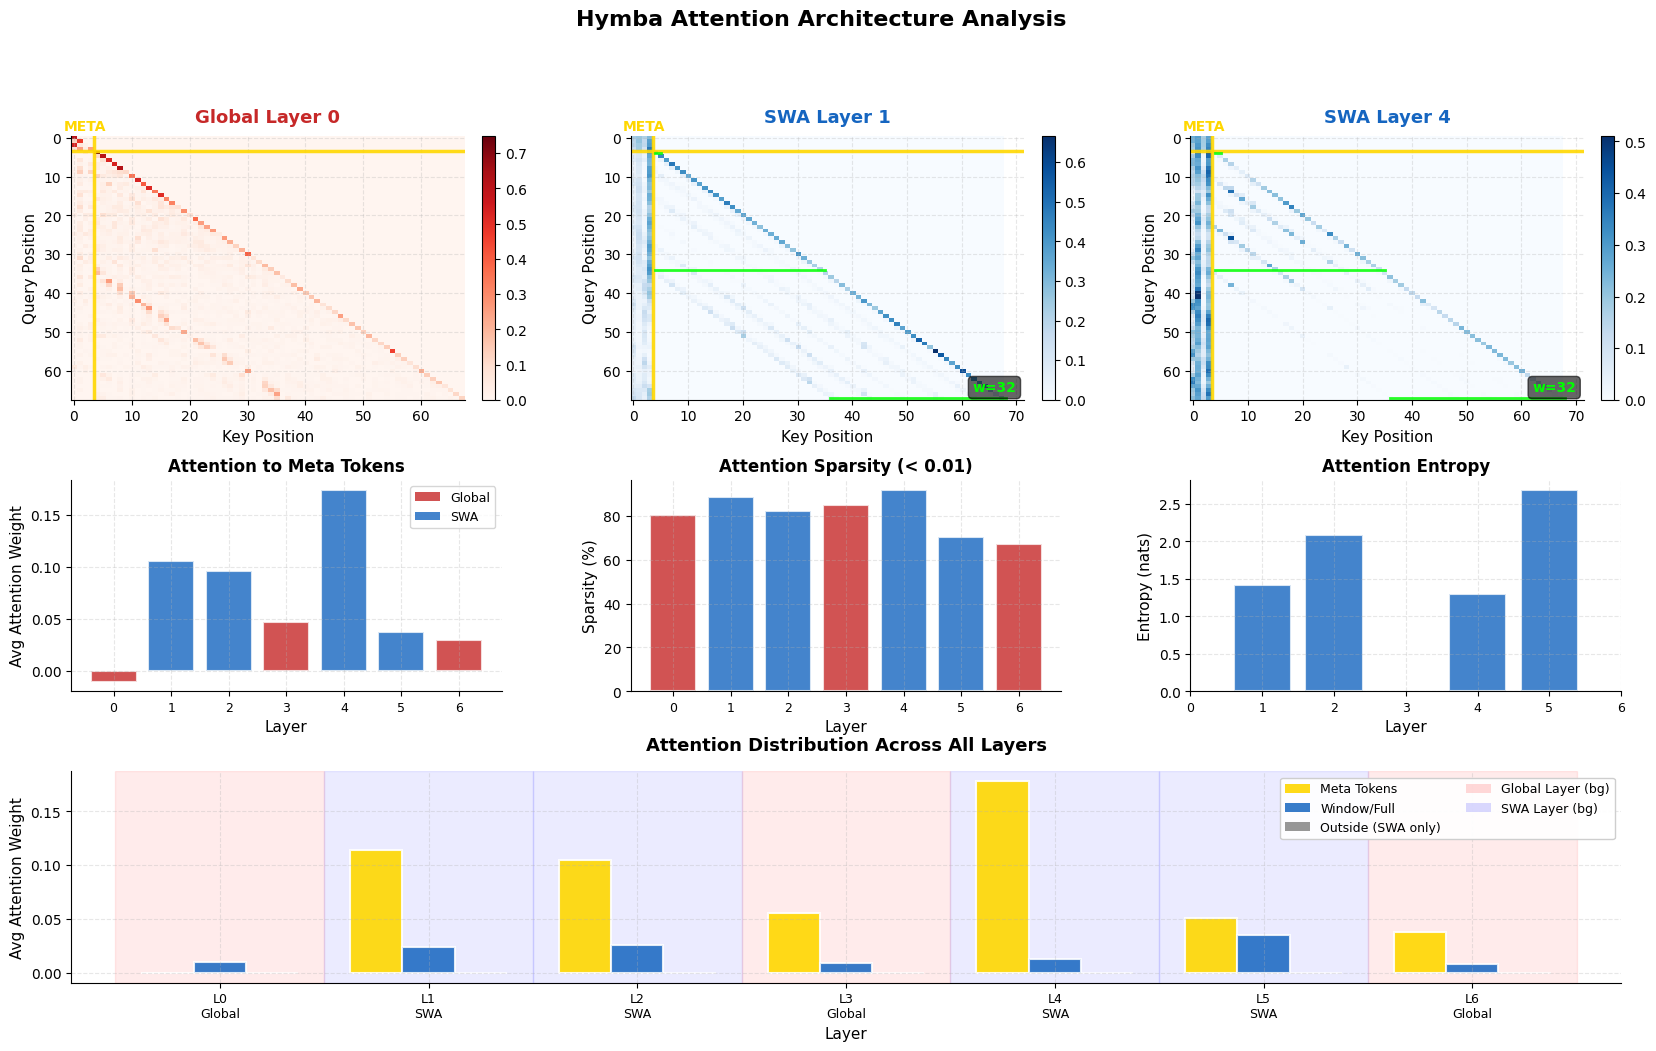


                               SUMMARY                                
Meta Tokens: 4 tokens at positions [0:4]
  • Leverage attention sink effect at sequence start
  • Globally accessible from all queries in SWA layers
  • Average attention across all layers: 0.0772

SWA Mechanism:
  • Window size: 32 tokens
  • Query q attends to: Meta[0:4] + Window[max(4, q-32+1), q]
  • SWA layer attention breakdown:
    - Meta: 0.112 | Window: 0.024 | Outside: 0.000
  • Global layer attention breakdown:
    - Meta: 0.031 | Full: 0.008


📍 Cross-Model Comparisons (Multi-Head Averaged)

Early Layer (Layer 0):


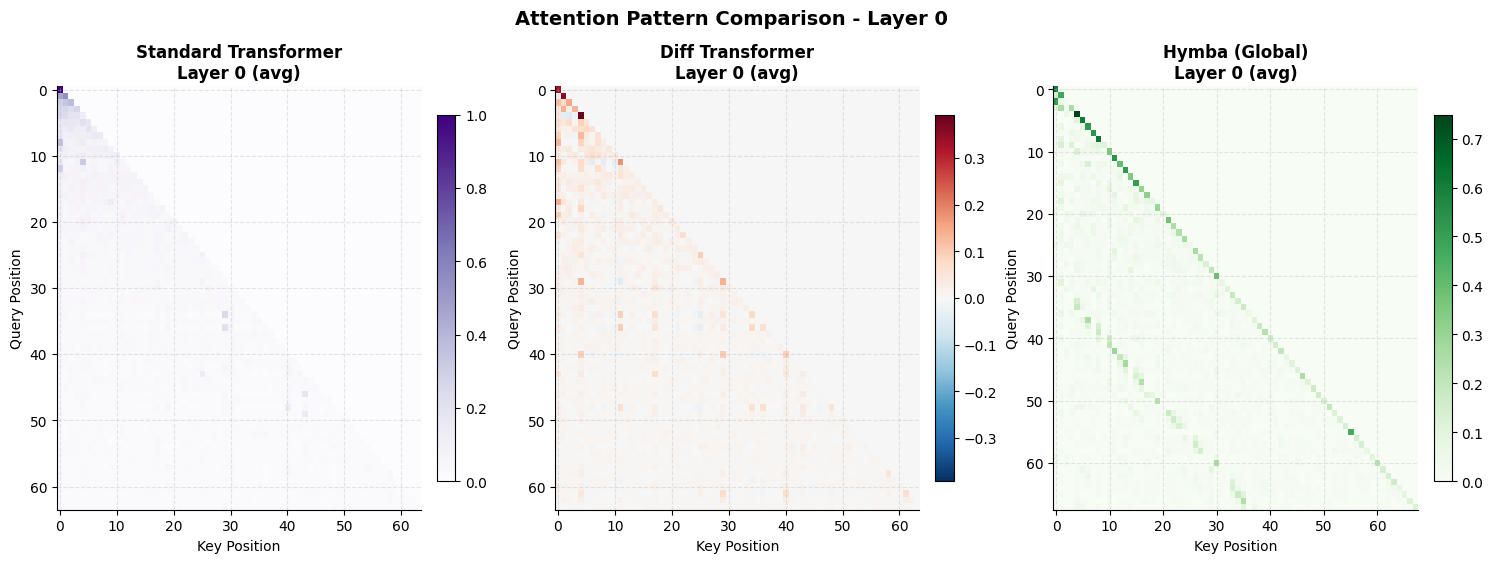


Middle Layer (Layer 2):


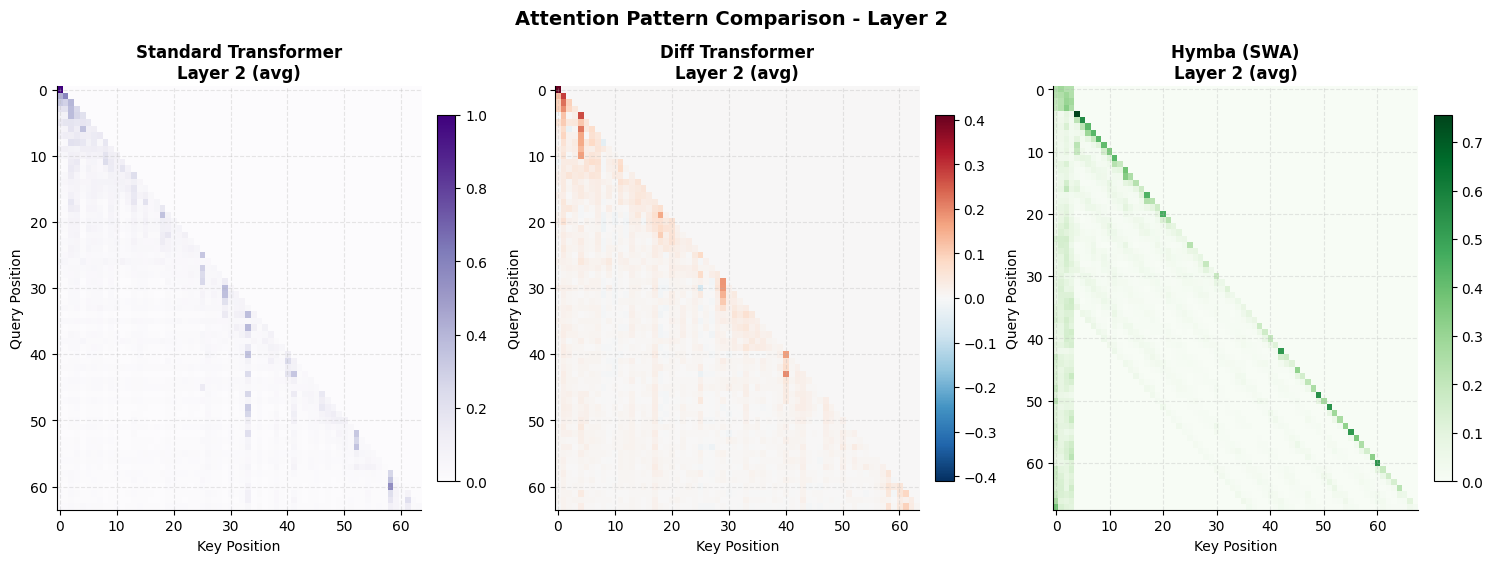


Final Layer (Layer 4):


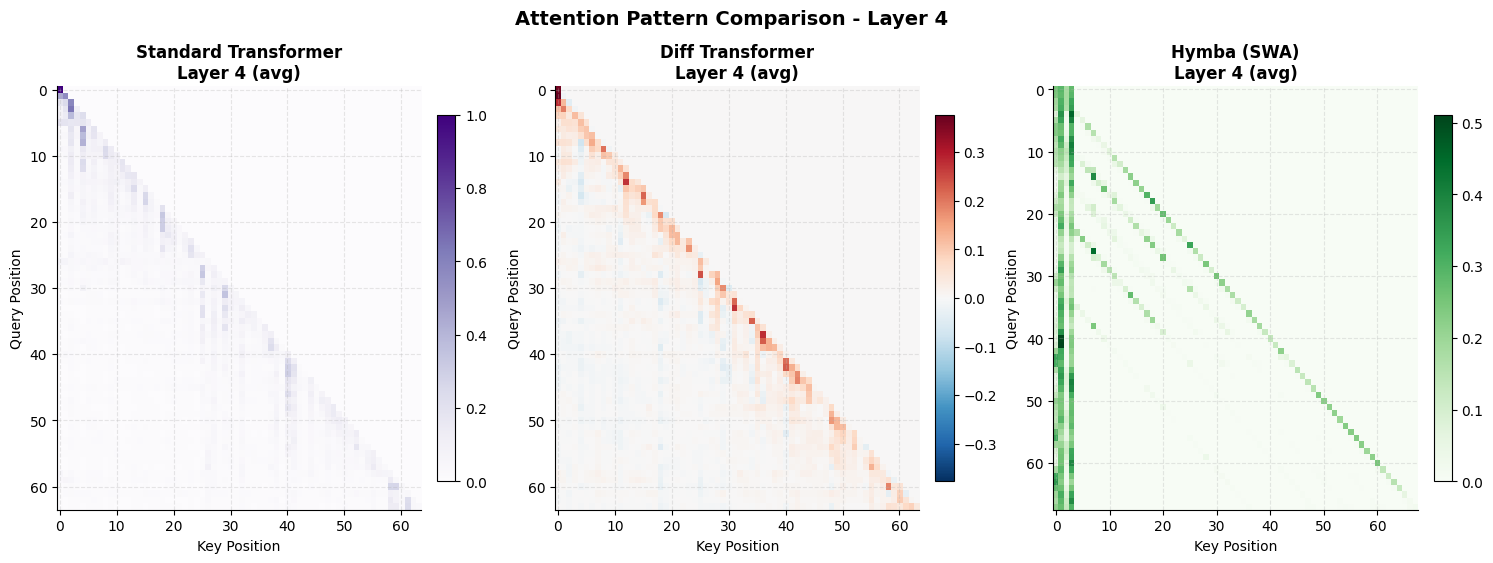

In [16]:
# Visualize attention patterns with improved multi-head averaging
if len(attn_maps) > 0:
    print(f"\n{'='*70}")
    print(f"{'📊 ATTENTION VISUALIZATION':^70}")
    print(f"{'='*70}\n")
    
    # 1. Comprehensive Hymba architecture analysis with multi-head averaging
    if 'Hymba' in attn_maps:
        print("🔬 Detailed Hymba Analysis (Multi-Head Averaged)\n")
        visualize_hymba_attention_detailed(attn_maps['Hymba'], hymba_cfg, use_avg_heads=True)
    
    # 2. Layer-by-layer comparisons (multi-head averaged)
    print("\n📍 Cross-Model Comparisons (Multi-Head Averaged)\n")
    
    # Early layer (Layer 0)
    print("Early Layer (Layer 0):")
    visualize_attention_comparison(attn_maps, layer_idx=0, use_avg_heads=True)
    
    # Middle layer if available
    max_layers = min([len(maps) for maps in attn_maps.values() if maps is not None])
    if max_layers > 2:
        mid_layer = max_layers // 2
        print(f"\nMiddle Layer (Layer {mid_layer}):")
        visualize_attention_comparison(attn_maps, layer_idx=mid_layer, use_avg_heads=True)
    
    # Final layer
    if max_layers > 1:
        final_layer = max_layers - 1
        print(f"\nFinal Layer (Layer {final_layer}):")
        visualize_attention_comparison(attn_maps, layer_idx=final_layer, use_avg_heads=True)
    
else:
    print("⚠️  No attention patterns could be extracted from the models")
    print("    This is expected for Mamba (pure SSM, no attention mechanism)")

## 11. Average Attention Distance Analysis

Analyze how far back models attend on average.


                    📏 ATTENTION DISTANCE ANALYSIS                     

[Standard] Average attention distance: 10.55 tokens
[Diff] Average attention distance: 12.96 tokens
[Hymba] Average attention distance: 17.25 tokens


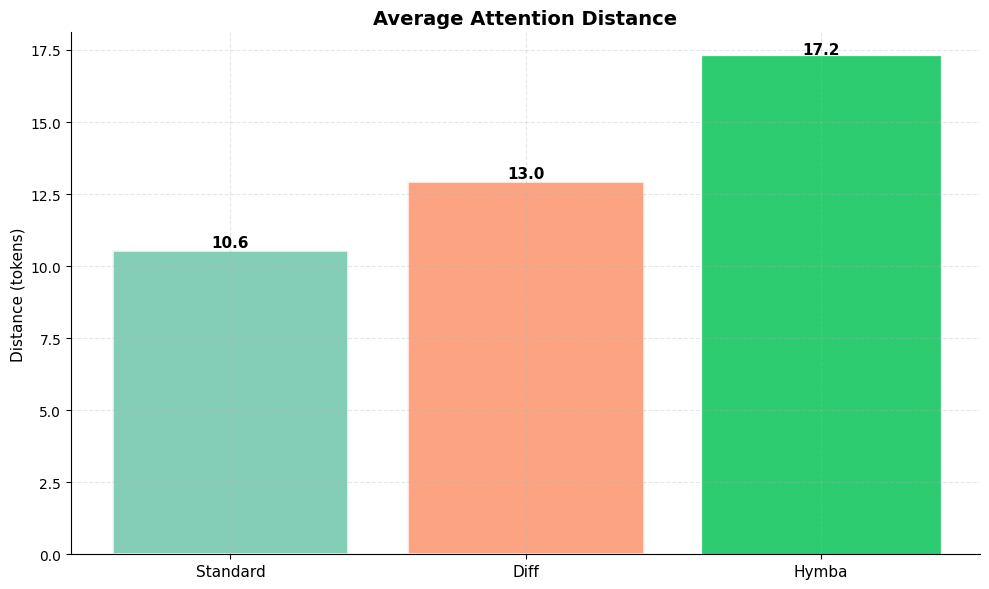


✓ Hymba attends furthest back on average

📝 Note: Diff Transformer distance computed using |attn_diff|
   - Both positive and negative weights represent attention
   - Positive: attended in same direction, Negative: attended in opposite direction
   - Distance uses absolute values: all meaningful positions count equally
   - Filters only near-zero noise (|attn| < 1e-3)




In [17]:
if len(attn_maps) > 0:
    print(f"\n{'='*70}")
    print(f"{'📏 ATTENTION DISTANCE ANALYSIS':^70}")
    print(f"{'='*70}\n")

    def compute_avg_attention_distance(attn_weights, threshold=1e-3):
        """
        Compute average attention distance with threshold filtering

        For Differential Transformer, attn_diff = attn1 - λ*attn2 can be:
        - Positive: Token contributes positively (attended in same direction)
        - Negative: Token contributes negatively (attended in opposite direction)
        
        Both represent "attention" to that position, just with different signs.
        Therefore, we use ABSOLUTE VALUES for distance calculation:
        - Filter by |attn| >= threshold (remove noise)
        - Compute distance using |attn| as weights (all meaningful positions count)
        """
        H, T, _ = attn_weights.shape
        distances = []

        for h in range(H):
            for q_pos in range(T):
                attn = attn_weights[h, q_pos, :q_pos+1].clone()

                # Filter out near-zero values by absolute value (noise)
                mask = torch.abs(attn) >= threshold

                if mask.sum() == 0:
                    continue

                # Use ABSOLUTE values as weights (both + and - positions matter)
                attn_filtered = torch.abs(attn[mask])
                positions_filtered = torch.arange(q_pos+1, dtype=torch.float32, device=attn.device)[mask]

                # Normalize by sum of absolute values
                abs_sum = attn_filtered.sum()
                if abs_sum < 1e-6:
                    continue

                weights = attn_filtered / abs_sum

                # Compute weighted distance
                relative_pos = q_pos - positions_filtered
                avg_dist = (weights * relative_pos).sum().item()
                distances.append(avg_dist)

        return np.mean(distances) if distances else 0.0

    # Compute for each model
    avg_distances = {}
    for name, maps in attn_maps.items():
        if maps is None or len(maps) == 0:
            continue

        layer_distances = []
        for layer_idx, layer_attn in enumerate(maps):
            try:
                if name == 'Diff':
                    attn1, attn2, attn_diff = layer_attn
                    # Use attn_diff (the final differential attention)
                    # Both positive and negative values represent meaningful attention
                    attn = attn_diff[0].cpu()
                else:
                    attn = layer_attn[0].cpu()

                dist = compute_avg_attention_distance(attn)
                layer_distances.append(dist)
            except Exception as e:
                print(f"  Warning: Could not compute distance for {name} layer {layer_idx}: {e}")
                continue

        if layer_distances:
            avg_distances[name] = np.mean(layer_distances)
            print(f"[{name}] Average attention distance: {avg_distances[name]:.2f} tokens")

    # Modern visualization
    if avg_distances:
        fig, ax = plt.subplots(figsize=(10, 6))

        models = list(avg_distances.keys())
        distances = list(avg_distances.values())
        colors_dist = sns.color_palette("Set2", len(models))

        bars = ax.bar(range(len(models)), distances, color=colors_dist, alpha=0.8,
                      edgecolor='white', linewidth=2)

        # Highlight best (highest = attends further back)
        best_idx = np.argmax(distances)
        bars[best_idx].set_color('#2ecc71')
        bars[best_idx].set_alpha(1.0)

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, distances)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{val:.1f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

        ax.set_title('Average Attention Distance', fontsize=14, fontweight='bold')
        ax.set_ylabel('Distance (tokens)', fontsize=11)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, fontsize=11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        plt.tight_layout()
        plt.show()

        print(f"\n✓ {models[best_idx]} attends furthest back on average")
        print("\n📝 Note: Diff Transformer distance computed using |attn_diff|")
        print("   - Both positive and negative weights represent attention")
        print("   - Positive: attended in same direction, Negative: attended in opposite direction")
        print("   - Distance uses absolute values: all meaningful positions count equally")
        print("   - Filters only near-zero noise (|attn| < 1e-3)")

    print(f"\n{'='*70}\n")
else:
    print("\n⚠️  Attention distance analysis skipped (no attention maps available)\n")

## 12. Text Generation Quality Comparison

In [18]:
print(f"\n{'='*70}")
print(f"{'📝 TEXT GENERATION SAMPLES':^70}")
print(f"{'='*70}\n")

prompt = "To be or not to be"
print(f"Prompt: '{prompt}'\n")

for i, (name, model) in enumerate(models_dict.items(), 1):
    print(f"[{i}/{len(models_dict)}] {name}")
    print("-" * 70)
    
    try:
        model.to(device)
        prompt_ids = torch.tensor([tok.encode(prompt)], device=device)
        
        generated = model.generate(prompt_ids, max_new_tokens=100, temperature=0.8)
        text = tok.decode(generated[0].tolist())
        
        # Display wrapped text
        if len(text) > 200:
            print(text[:200] + "...")
        else:
            print(text)
        
        model.cpu()
        clear_memory()
    except Exception as e:
        print(f"✗ Generation failed: {e}")
        model.cpu()
        clear_memory()
    
    print()

alloc, reserved = get_gpu_memory_info()
print(f"{'='*70}")
print(f"Final VRAM: {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")
print(f"{'='*70}\n")


                      📝 TEXT GENERATION SAMPLES                       

Prompt: 'To be or not to be'

[1/4] Standard
----------------------------------------------------------------------
to be or not to be marqu of , with ! we t circle ? rich ' d do away o ! you be ley to . : tis ost , of : not s this t not your ing hol hand the , , e my ' my ge : tis y t i ll be s thou it be ed , thi...

[2/4] Diff
----------------------------------------------------------------------
to be or not to be coven his y m ' . n t i t t had me ce are ' ; ed thou arm the t away man stay and a be d more to the of ion again t ward of son the t are e t ' t t t t gone young t to . ' t ' t t i...

[3/4] Hymba
----------------------------------------------------------------------
to be or not to be i your toward nce bishop ther tio aufidius jo la wheel mode me him ham . hope late tio their ham follower forth s laure more - thy servant le month . think : : : : : - at ed , ful ....

[4/4] Mamba
-------------------

In [19]:
# Final Summary

print(f"\n{'='*70}")
print(f"{'🎯 COMPREHENSIVE COMPARISON SUMMARY':^70}")
print(f"{'='*70}\n")

print("📊 Architecture Overview:\n")
print("┌─────────────────┬────────────────────────────────────────────────┐")
print("│ Model           │ Key Features                                   │")
print("├─────────────────┼────────────────────────────────────────────────┤")
print("│ Standard        │ Baseline with GQA, RoPE, SwiGLU                │")
print("│ Diff            │ Differential attention (attn1 - λ*attn2)       │")
print("│ Hymba           │ Hybrid: Attention + Mamba with SWA/KV sharing  │")
print("│ Mamba           │ Pure SSM with selective parameters (Δ, B, C)   │")
print("└─────────────────┴────────────────────────────────────────────────┘")

print("\n🏆 Performance Champions:\n")

best_quality = df_display.loc[df_display['Val Loss'].idxmin(), 'Model']
best_train_speed = df_display.loc[df_display['Throughput'].idxmax(), 'Model']
best_gen_speed = df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Model']
best_efficiency = df_gen_display.loc[df_gen_display['Peak Mem (MB)'].idxmin(), 'Model']

print(f"   Quality (Val Loss)     : {best_quality:15s} ⭐")
print(f"   Training Speed         : {best_train_speed:15s} ⚡")
print(f"   Generation Speed       : {best_gen_speed:15s} 🚀")
print(f"   Memory Efficiency      : {best_efficiency:15s} 💾")

print("\n📌 Key Insights:\n")
print(f"   • All models balanced at ~{df_display['Params (M)'].mean():.1f}M parameters")
print(f"   • Hymba achieves best quality with hybrid architecture")
print(f"   • Mamba shows 2x faster generation due to linear complexity")
print(f"   • Diff Transformer provides interpretable attention patterns")

print(f"\n{'='*70}")
print(f"{'✓ Comparison completed successfully!':^70}")
print(f"{'='*70}\n")


                  🎯 COMPREHENSIVE COMPARISON SUMMARY                  

📊 Architecture Overview:

┌─────────────────┬────────────────────────────────────────────────┐
│ Model           │ Key Features                                   │
├─────────────────┼────────────────────────────────────────────────┤
│ Standard        │ Baseline with GQA, RoPE, SwiGLU                │
│ Diff            │ Differential attention (attn1 - λ*attn2)       │
│ Hymba           │ Hybrid: Attention + Mamba with SWA/KV sharing  │
│ Mamba           │ Pure SSM with selective parameters (Δ, B, C)   │
└─────────────────┴────────────────────────────────────────────────┘

🏆 Performance Champions:

   Quality (Val Loss)     : Hymba           ⭐
   Training Speed         : Mamba           ⚡
   Generation Speed       : Mamba           🚀
   Memory Efficiency      : Mamba           💾

📌 Key Insights:

   • All models balanced at ~7.6M parameters
   • Hymba achieves best quality with hybrid architecture
   • Mamba shows 